In [1]:
!pip -q install keras "tensorflow==2.15.1" "onnx" "seaborn" "onnxruntime"


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import keras
import pickle
import pandas as pd
import numpy as np

2024-12-08 18:58:20.327854: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 18:58:20.399564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 18:58:20.399639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 18:58:20.401279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 18:58:20.411081: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 18:58:20.412322: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
keras_model = keras.saving.load_model("../2-dev_datascience/models/jukebox/1/model.keras")

In [6]:
#Load the scaler and label encoder
with open('../2-dev_datascience/models/jukebox/1/artifacts/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
    
with open('../2-dev_datascience/models/jukebox/1/artifacts/label_encoder.pkl', 'rb') as handle:
    label_encoder = pickle.load(handle)

In [7]:
# We pick the properties of our favorite song
song_properties = pd.read_parquet('../99-data_prep/song_properties.parquet')
favorite_song = song_properties.loc[song_properties["name"]=="Not Like Us"]
favorite_song

,spotify_id,name,artists,snapshot_date,is_explicit,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
409964,6AI3ezQ4o3HUoP6Dhudph3,Not Like Us,Kendrick Lamar,2024-05-06,True,274192,0.898,0.472,1,-7.001,1,0.0776,0.0107,0.0,0.141,0.214,101.061,4


In [8]:
feature_df = favorite_song[['is_explicit', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
feature_df.T

,409964
is_explicit,True
duration_ms,274192
danceability,0.898
energy,0.472
key,1
loudness,-7.001
mode,1
speechiness,0.0776
acousticness,0.0107
instrumentalness,0.0


In [9]:
scaled_feature = scaler.transform(feature_df)[0]
scaled_feature

/opt/app-root/lib64/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([1.        , 0.27927992, 0.90890688, 0.47293528, 0.09090909,
       0.74772598, 1.        , 0.08425624, 0.01073549, 0.        ,
       0.1318328 , 0.21572581, 0.42839339])

In [10]:
feature_values = {
    "is_explicit": scaled_feature[0],
    "duration_ms": scaled_feature[1],
    "danceability": scaled_feature[2],
    "energy": scaled_feature[3],
    "key": scaled_feature[4],
    "loudness": scaled_feature[5],
    "mode": scaled_feature[6],
    "speechiness": scaled_feature[7],
    "acousticness": scaled_feature[8],
    "instrumentalness": scaled_feature[9],
    "liveness": scaled_feature[10],
    "valence": scaled_feature[11],
    "tempo": scaled_feature[12]
}

feature_df_2 = pd.DataFrame([feature_values])
feature_df_2.T

,0
is_explicit,1.000000
duration_ms,0.279280
danceability,0.908907
energy,0.472935
key,0.090909
loudness,0.747726
mode,1.000000
speechiness,0.084256
acousticness,0.010735
instrumentalness,0.000000


In [14]:
print(keras_model.predict(feature_df_2)[0][13])
# print(f"Paid loan is predicted as: {xgb.predict(feature_df)}")

1/1 [==============================] - 0s 86ms/step
0.0078033186


In [15]:
output_names = []
for i in range(72):
    output_names.append(f"output-{i}")

In [63]:
PRED_COUNTRY = "output-8"

In [64]:
def pred(x):
    pred = keras_model.predict(x)
    pred = np.squeeze(pred)
    pred = {output_names[i]: pred[i] for i in range(pred.shape[0])}
    print(pred[PRED_COUNTRY])
    if pred[PRED_COUNTRY] >= 0.3 and pred["output-2"] <= 0.9:
        pred = {PRED_COUNTRY: True}
    else:
        pred = {PRED_COUNTRY: False}
    return pd.DataFrame([pred])

In [65]:
from trustyai.model import Model

model = Model(pred, output_names=["output-8"])

In [66]:
from trustyai.model.domain import feature_domain
# domains = []
# for v in feature_df_2:
#     print(v)
#     if type(v) is bool:
#         domains.append(feature_domain([True, False]))
#     else:
#         domains.append(feature_domain((0.0, 10.0)))


_domains = {
        "is_explicit": (0.0, 1.0),
        "duration_ms": (0.0, 1.0),
        "danceability": (0.0, 1.0),
        "energy": (0.0, 1.0),
        "key": (0.0, 1.0),
        "loudness": (0.0, 1.0),
        "mode": (0.0, 1.0),
        "speechiness": (0.0, 1.0),
        "acousticness": (0.0, 1.0),
        "instrumentalness": (0.0, 1.0),
        "liveness": (0.0, 1.0),
        "valence": (0.0, 1.0),
        "tempo": (0.0, 1.0)
}
domains = {key: None for key  in feature_values.keys()}

for key in  _domains.keys():
        domains[key] = feature_domain(_domains[key])

domains = list(domains.values())

In [67]:
from trustyai.model import output
# goal = []
# for output_name in output_names:
#     goal.append(output(name=output_name, dtype="float", value=0.1))
goal = [output(name=PRED_COUNTRY, dtype="bool", value=True)]

In [68]:
pred(feature_df_2)[PRED_COUNTRY]

1/1 [==============================] - 0s 23ms/step
0.0036883364


0    False
Name: output-8, dtype: bool

In [69]:
from trustyai.explainers import CounterfactualExplainer

explainer = CounterfactualExplainer(steps=50)
explanation = explainer.explain(inputs=feature_df_2, goal=goal, model=model, feature_domains=domains)

1/1 [==============================] - 0s 25ms/step
0.0036883364
1/1 [==============================] - 0s 23ms/step
0.0036883364
1/1 [==============================] - 0s 24ms/step
0.002417213
1/1 [==============================] - 0s 23ms/step
0.026813423
1/1 [==============================] - 0s 23ms/step
0.018899089
1/1 [==============================] - 0s 24ms/step
0.00014057646
1/1 [==============================] - 0s 24ms/step
6.0937117e-07
1/1 [==============================] - 0s 24ms/step
0.0066301967
1/1 [==============================] - 0s 24ms/step
0.026572675
1/1 [==============================] - 0s 23ms/step
0.00055242283
1/1 [==============================] - 0s 24ms/step
0.0010782102
1/1 [==============================] - 0s 24ms/step
0.002910934
1/1 [==============================] - 0s 23ms/step
3.8382757e-05
1/1 [==============================] - 0s 24ms/step
1.5554662e-05
1/1 [==============================] - 0s 24ms/step
3.780152e-07
1/1 [====================

In [70]:
model(explanation.proposed_features_dataframe)

1/1 [==============================] - 0s 24ms/step
0.39725867


,output-8
0,True


In [71]:
explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,is_explicit,1.000000,1.000000,False,0.000000
1,duration_ms,0.908907,0.279280,False,0.629627
2,danceability,0.279280,0.908907,False,-0.629627
3,energy,0.472935,0.472935,False,0.000000
4,key,0.090909,0.090909,False,0.000000
5,loudness,0.747726,0.747726,False,0.000000
6,mode,1.000000,1.000000,False,0.000000
7,speechiness,0.084256,0.084256,False,0.000000
8,acousticness,0.010735,0.010735,False,0.000000
9,instrumentalness,0.000000,0.000000,False,0.000000


In [72]:
df = explanation.as_dataframe()
df[df.difference != 0.0]

,features,proposed,original,constrained,difference
1,duration_ms,0.908907,0.279280,False,0.629627
2,danceability,0.279280,0.908907,False,-0.629627


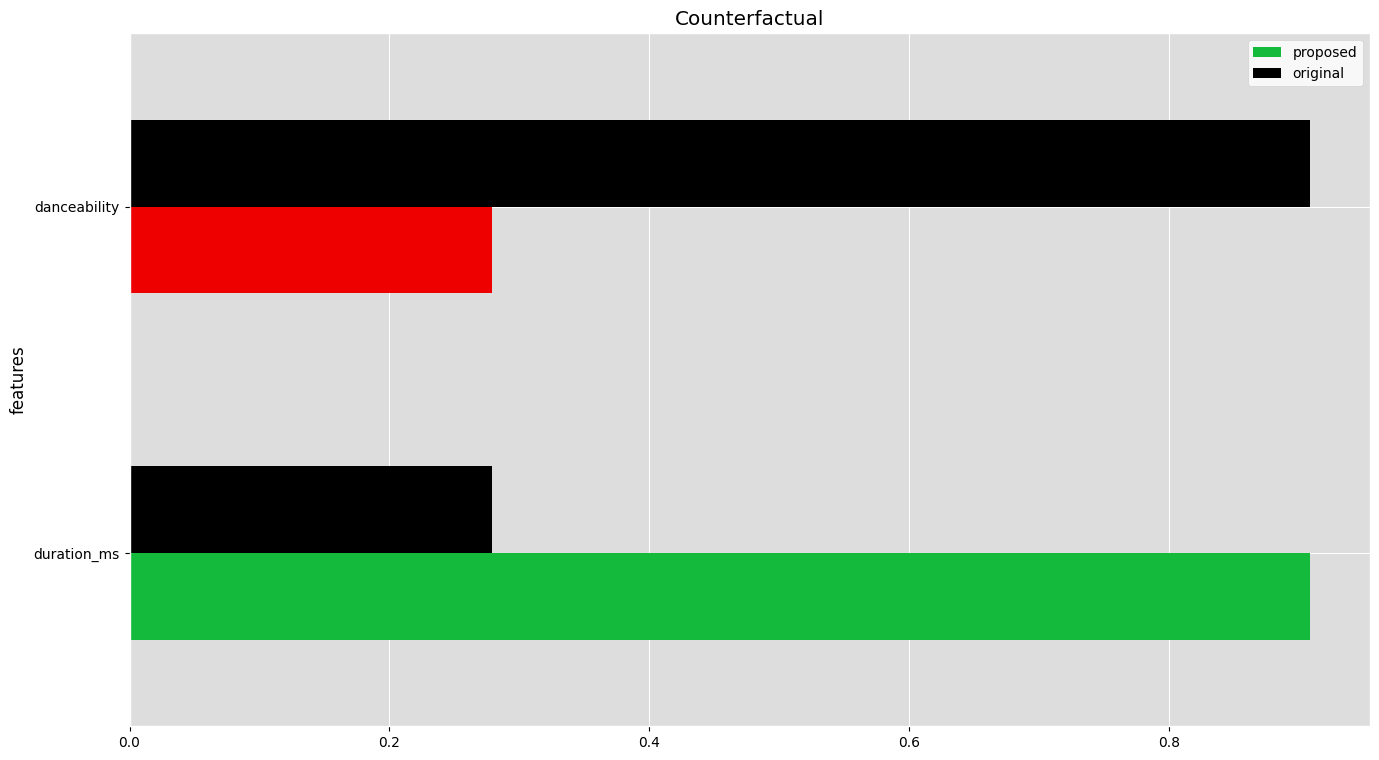

In [73]:
explanation.plot()